# Gibb's Sampling

In [1]:
import numpy as np
from scipy.special import expit
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
def dkl(p, q):
    dkl_sum = 0
    for x, y in zip(p, q):
        if x != 0:
            dkl_sum += x * np.log(x/y)
    return dkl_sum


In [11]:
# Creates random Boltzmann Machine and samples from it using Gibb's Sampling. 
# Also compares to exact distribution.

N = 10 # number of units
tau_ref = 1 # ms
iterations = int(1e5) 
weights = np.random.rand(N, N)
weights = ((weights + weights.T)/2 - 0.5)*2 # symmetrize, remove diagonals
for i in range(N):
    weights[i,i] = 0
biases = (np.random.rand(N)-0.5)*2
initial_state = np.zeros(N)
dkl_list = np.empty(iterations)
state = initial_state
state_list = []
# calculate exact p
p_exact = np.zeros(2**N)
for exact_state_int in xrange(2**N):
    # create vector representation of state
    exact_state_vec = np.array([1 if (exact_state_int & 2**x) else 0 for x in xrange(N)])
    energy = -(0.5*np.dot(exact_state_vec.T, np.dot(weights, exact_state_vec)) + np.dot(biases, exact_state_vec))
    p_exact[exact_state_int] = np.exp(-energy)
p_exact = p_exact / np.sum(p_exact) # normalize
t = 0
avg_window = 100
rates = np.zeros((iterations+1, N))
spike_sums = np.zeros((iterations+1, N))
membrane_potentials = np.zeros((iterations, N))
for i in tqdm_notebook(xrange(iterations)):
    t += tau_ref
    for j in range(N):
        membrane_potential = np.dot(weights, state)[j] + biases[j]
        membrane_potentials[i][j] = membrane_potential
        state[j] = np.random.binomial(1, expit(membrane_potential))
        spike_sums[i+1][j] = spike_sums[i][j] + state[j]
        if i+1-avg_window > 0:
            rates[i+1][j] = (spike_sums[i+1][j] - spike_sums[i+1-avg_window][j])/(avg_window*tau_ref)
    state_sum = np.sum(np.power(2, np.where(state == 1))) # format state as integer
    state_list.append(state_sum)
    p_estimate = np.bincount(state_list, minlength=2**N) / float(len(state_list))
    dkl_list[i] = dkl(p_estimate, p_exact)    

KeyboardInterrupt: 

10299/|/ 10%|| 10299/100000 [00:45<06:32, 228.55it/s]

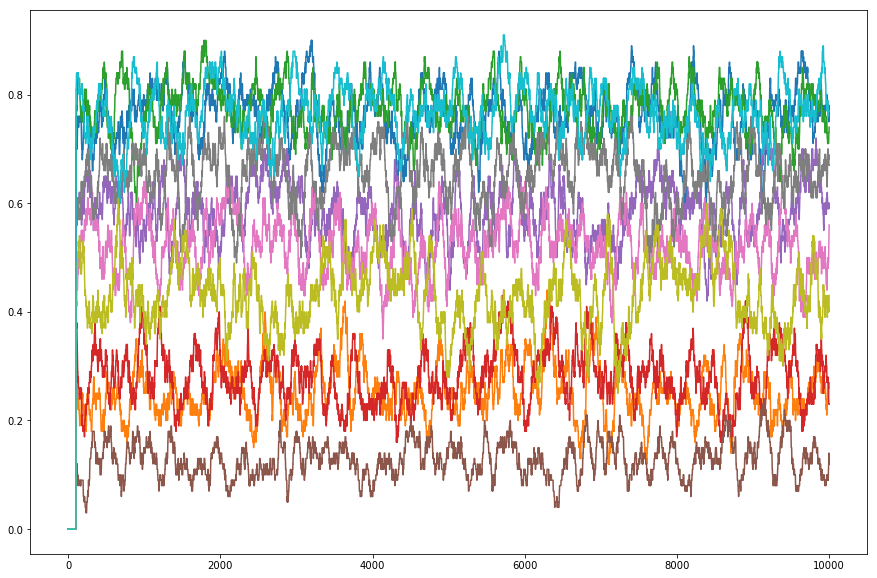

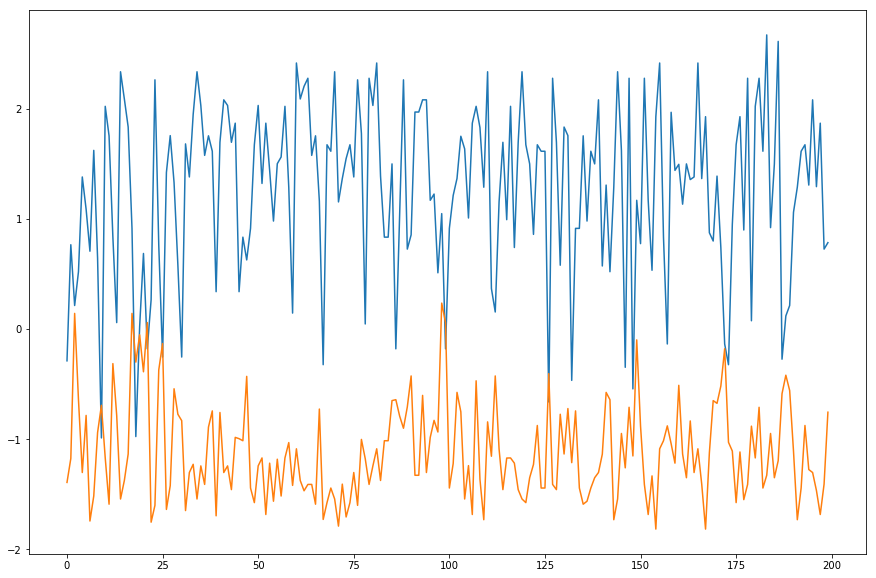

In [16]:
plt.figure(figsize=(15,10))
for i in range(N):
    plt.plot(rates[:10000, i])
plt.figure(figsize=(15,10))
for i in range(2):
    plt.plot(membrane_potentials[:200, i])

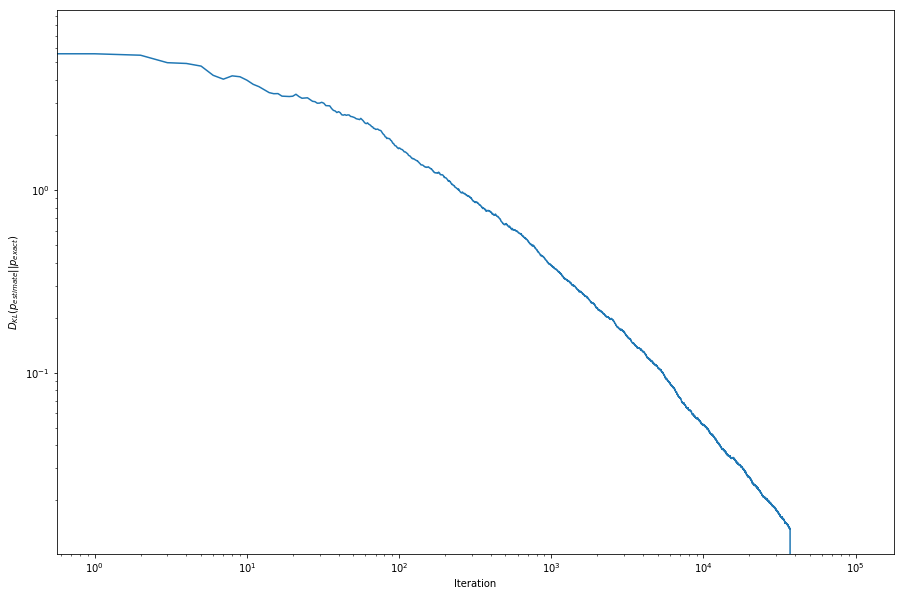

In [10]:
plt.figure(figsize=(15,10))
plt.plot(range(len(dkl_list)), dkl_list)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Iteration")
plt.ylabel("$D_{KL}(p_{estimate}||p_{exact})$")

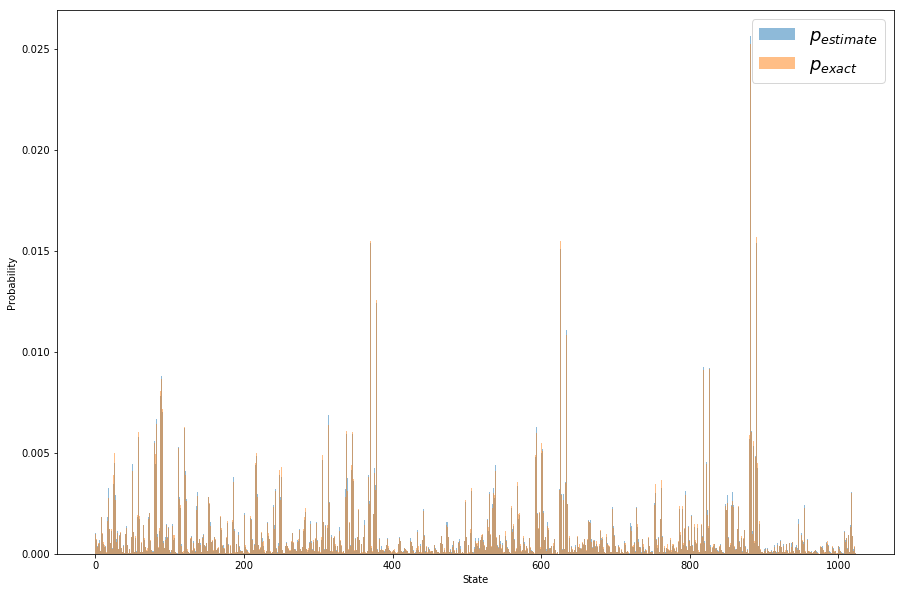

In [212]:
plt.figure(figsize=(15, 10))
plt.bar(range(len(p_estimate)), p_estimate, 1., alpha=0.5, label="$p_{estimate}$")
plt.bar(range(len(p_exact)), p_exact, 1., alpha=0.5, label="$p_{exact}$")
plt.xlabel("State")
plt.ylabel("Probability")
plt.legend(fontsize=18)